In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
raw_df = pd.read_csv('train-balanced-sarcasm.csv')
raw_df.isnull().sum()
raw_df.dropna(inplace=True)
raw_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [3]:
# filter out the sarcastic comments
sarcastic_comments = raw_df[raw_df['label'] == 1]

# filter out the non-sarcastic comments
n_sarcastic_comments = raw_df[raw_df['label'] == 0]

# Topic Modelling

In [4]:
# Function to preprocess text and return words as a comma-separated string
def preprocess_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()
    # Step 2: Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Step 3: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Step 4: Remove stopwords (common words like "the," "is," etc.)
    text = " ".join([word for word in nltk.word_tokenize(text) if word.lower() not in stopwords.words('english')])
    # Step 5: Remove short words (length < 3)
    text = " ".join([word for word in nltk.word_tokenize(text) if len(word) >= 3])
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each word in the text
    text = " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])
    return text

In [5]:
sarcastic_parent_processed = []


for text in tqdm(sarcastic_comments["parent_comment"]):
    # Step 6: Preprocess the text
    preprocessed_text = preprocess_text(text)
    # Step 7: Lemmatize the preprocessed text
    preprocessed_text = lemmatize_text(preprocessed_text)
    # Append the processed text to the list
    sarcastic_parent_processed.append(preprocessed_text)


100%|██████████| 505368/505368 [56:25<00:00, 149.29it/s]   


In [22]:
sarcastic_parent_processed[:10]

['dumb thing risking seller account',
 'clinton campaign accuses fbi blatant double standard',
 'anyone else think interesting way mentioned tape recorder hand assaulting',
 'here happens obama give twitter account',
 'monday night drinking thread brought infuriating capitalization inconsistency',
 'except lakers',
 'little self lovin turn turn frown upside beat like money',
 'make predator think theyre poisonous',
 'pretty inconvenient landed anywhere pres',
 'everyone else missing entire point point make decision without violence government bring table free market responsible far safety equipment government cheer']

In [6]:
# vectorize the parent_comment and comment columns
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vec_parent = vectorizer.fit_transform(sarcastic_parent_processed)

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=42, max_iter=1)

In [8]:
lda_top = lda_model.fit_transform(vec_parent)

In [9]:
print(lda_model.components_)

[[0.11273473 0.11187134 0.11173614 ... 0.11038436 0.11129831 0.10942539]
 [0.48820127 0.46764587 0.11360267 ... 0.18244984 0.18145427 0.17537709]
 [0.11445558 0.11041554 0.11311412 ... 0.11026864 0.11021109 0.11364938]
 ...
 [0.11131767 0.11434443 0.110449   ... 0.11040086 0.11212837 0.11117899]
 [0.14412209 0.12433778 0.10717333 ... 0.11267043 0.10988101 0.11009547]
 [0.29643499 0.33277077 0.1108883  ... 0.11359876 0.11016917 0.11158341]]


In [9]:
vocab = vectorizer.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
south banned album guilty gta tattoo michael anonymous seattle virginia 

Topic 1: 
bush truth violence kinda university tea india nsfw website irony 

Topic 2: 
hilarious president obama kobe cringe fbi tit pure slut non mouse 

Topic 3: 
apple income secret chicken fixed lord pet brave download climate change 

Topic 4: 
canadian africa minecraft file nasa socialism palin gamers amazon harper 

Topic 5: 
dollar romney abortion fox news penis teach perhaps breaking upvote catholic 

Topic 6: 
like people dont get would one think know make time 

Topic 7: 
gender dont believe knife troop egypt dare soul net stereotype thats pretty 

Topic 8: 
sarcasm ron paul font tsa senator screw steve creep cnn deleted 

Topic 9: 
usa kidding warning blood disease positive trailer peasant circlejerk snow 



c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\word

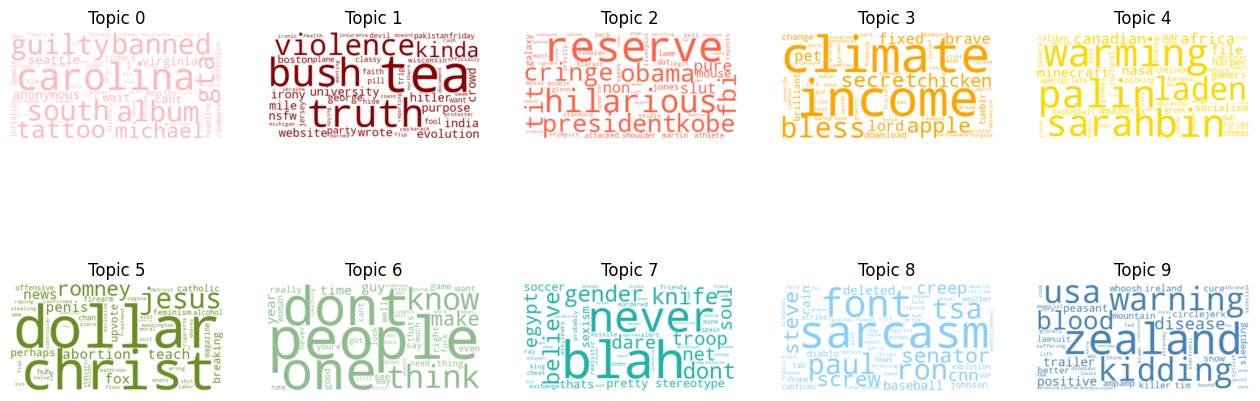

In [88]:
from wordcloud import WordCloud

topic_colors = ['lightpink', 'darkred', 'tomato', 'orange', 'gold', 'olivedrab', 'darkseagreen', 'lightseagreen', 'lightskyblue', 'steelblue']

topic_wordclouds = []

for i in range(num_topics):
    imp_words_topic=""
    comp=lda_model.components_[i]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
      imp_words_topic=imp_words_topic+" "+word[0]
    
    # Generate word cloud with the topic's color
    wordcloud = WordCloud(width=400, height=200, background_color='white', color_func=lambda *args, **kwargs: topic_colors[i]).generate(imp_words_topic)
    topic_wordclouds.append(wordcloud)

plt.figure(figsize=(16, 6))
for i, wordcloud in enumerate(topic_wordclouds):
    plt.subplot(2, 5, i+1) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Topic {}'.format(i))
    plt.axis("off")

plt.show()

In [18]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
dash = pyLDAvis.lda_model.prepare(lda_model, vec_parent, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6     -49.267368   6.520429       1        1  58.907939
1       0.232683   5.432134       2        1   5.266641
5      17.904043 -28.517872       3        1   5.051402
7       8.445633  30.137560       4        1   4.541584
0      26.249880   0.323685       5        1   4.536650
4     -37.797779 -25.232515       6        1   4.431447
9     -24.490877  -0.624463       7        1   4.377335
3     -13.051619 -44.234581       8        1   4.362024
2      -6.834074 -18.953136       9        1   4.285325
8     -22.621572  27.275223      10        1   4.239654, topic_info=               Term         Freq        Total Category  logprob  loglift
1599916        like  2285.000000  2285.000000  Default  30.0000  30.0000
2052612      people  2262.000000  2262.000000  Default  29.0000  29.0000
781943         dont  2085.000000  2085.000000  Default  28.0000  28.0000
1134969         get  1826.000000  1826.000000  Default  27.0000  27.0000
3196558       would  1808.000000  1808.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
2377688  rick perry     9.717159     9.973520  Topic10  -9.0796   3.1346
2059766      pepper     9.571609     9.828413  Topic10  -9.0947   3.1342
2467671       scout     9.310702     9.568474  Topic10  -9.1223   3.1334
356390     browsing     9.200118     9.457091  Topic10  -9.1343   3.1331
2440061     sarcasm    85.752673   224.322855  Topic10  -6.9020   2.1991

[350 rows x 6 columns], token_table=         Topic      Freq        Term
term                                
4882         3  1.002004    abortion
9856         4  1.002980      accent
47711        6  0.979537      africa
64259        5  1.002302       album
64777        3  0.998771     alcohol
...        ...       ...         ...
3202205      2  0.980169  would want
3211554      2  0.982772       wrote
3221998      1  0.999678        year
3237256      1  0.999569       youre
3243791      7  0.997517     zealand

[341 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 6, 8, 1, 5, 10, 4, 3, 9])

In [19]:
pyLDAvis.save_html(dash, 'lda_visualization.html')

## How to interpret this graph?
- Topics on the left while their respective keywords are on the right.
- Larger topics are more frequent and closer the topics, mor the similarity.
- Selection of keywords is based on their frequency and discriminancy.


# Sentiment Analysis

In [20]:
# Calculate sentiment score using BERT
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.eval()

def calculate_sentiment_labels(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1) 
    return predictions.numpy()



c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
raw_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,sentiment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",1
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,1
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,0
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,0
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,0


In [35]:
def sentiment_analyzer_score(sentence):
    score = analyzer.polarity_scores(sentence)
    return score

sentiment_score = raw_df["comment"].apply(sentiment_analyzer_score)
vaders = pd.DataFrame(sentiment_score)

sentiment_df = vaders['comment'].apply(pd.Series)
sentiment = pd.concat([vaders, sentiment_df], axis=1)
sentiment.drop('comment', axis=1, inplace=True)

In [73]:
parent_sentiment_score = raw_df["parent_comment"].apply(sentiment_analyzer_score)
parent_vaders = pd.DataFrame(parent_sentiment_score)

parent_sentiment_df = parent_vaders['parent_comment'].apply(pd.Series)
parent_sentiment = pd.concat([parent_vaders, parent_sentiment_df], axis=1)
parent_sentiment.drop('parent_comment', axis=1, inplace=True)

In [74]:
parent_sentiment.head()

,neg,neu,pos,compound
0,0.126,0.657,0.217,0.2023
1,0.095,0.905,0.000,-0.3412
2,0.000,0.233,0.767,0.7650
3,0.000,0.517,0.483,0.5773
4,0.000,0.879,0.121,0.2960


In [36]:
sentiment.head()

,neg,neu,pos,compound
0,0.000,0.337,0.663,0.6037
1,0.000,0.844,0.156,0.3400
2,0.000,1.000,0.000,0.0000
3,0.179,0.821,0.000,-0.3412
4,0.000,1.000,0.000,0.0000


In [37]:
raw_df["sentiment"] = sentiment["compound"]
raw_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,sentiment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",0.6037
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,0.3400
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,0.0000
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,-0.3412
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,0.0000


In [75]:
raw_df['parent_sentiment'] = parent_sentiment["compound"]
raw_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,sentiment,parent_sentiment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10-01,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",0.6037,0.2023
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11-01,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,0.3400,-0.3412
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09-01,2016-09-22 21:45:37,They're favored to win.,0.0000,0.7650
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10-01,2016-10-18 21:03:47,deadass don't kill my buzz,-0.3412,0.5773
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12-01,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,0.0000,0.2960


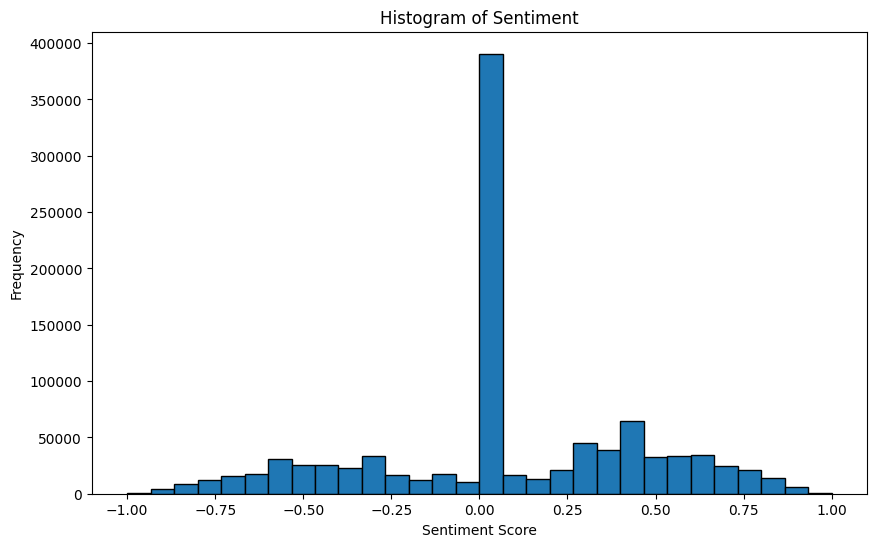

In [87]:
plt.figure(figsize=(10, 6))
plt.hist(raw_df['sentiment'], bins=30, edgecolor='black')
plt.title('Histogram of Sentiment')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [69]:
import seaborn as sns

raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df['date'] = raw_df['date'].dt.normalize()

new_df = raw_df.copy()
new_df['year'] = raw_df['date'].dt.year
new_df.rename(columns={'label': 'sarcasm'}, inplace=True)


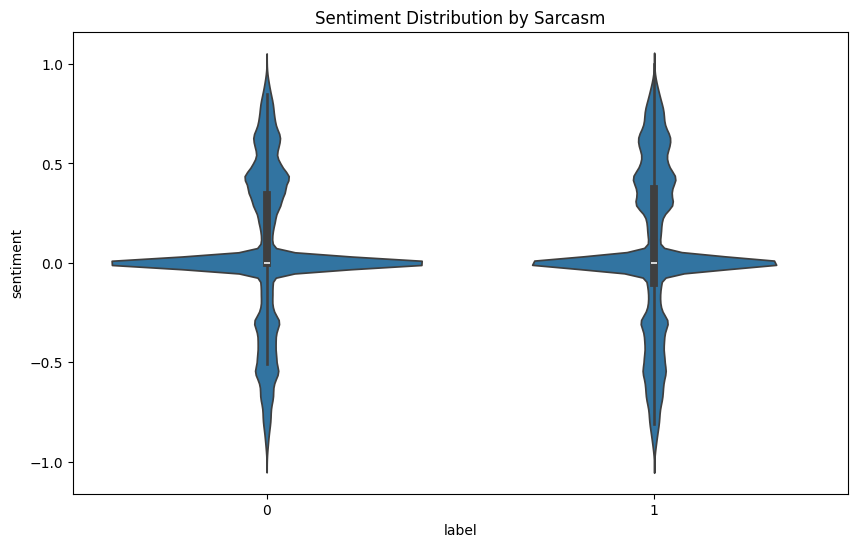

In [84]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='sentiment', data=raw_df)
plt.title('Sentiment Distribution by Sarcasm')
plt.show()

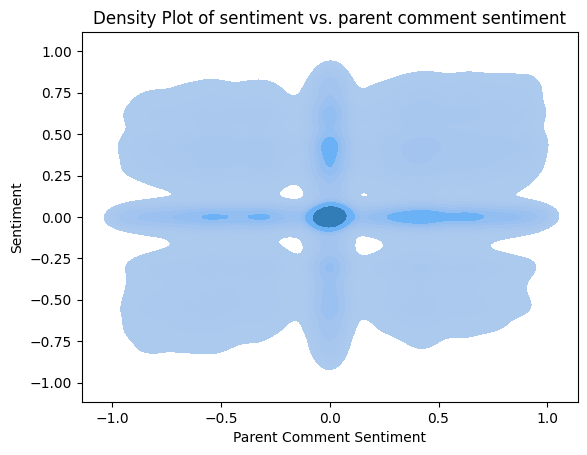

In [82]:
sns.kdeplot(data=raw_df, x="parent_sentiment", y="sentiment", fill=True)
plt.title("Density Plot of sentiment vs. parent comment sentiment")
plt.xlabel("Parent Comment Sentiment")
plt.ylabel("Sentiment")
plt.show()

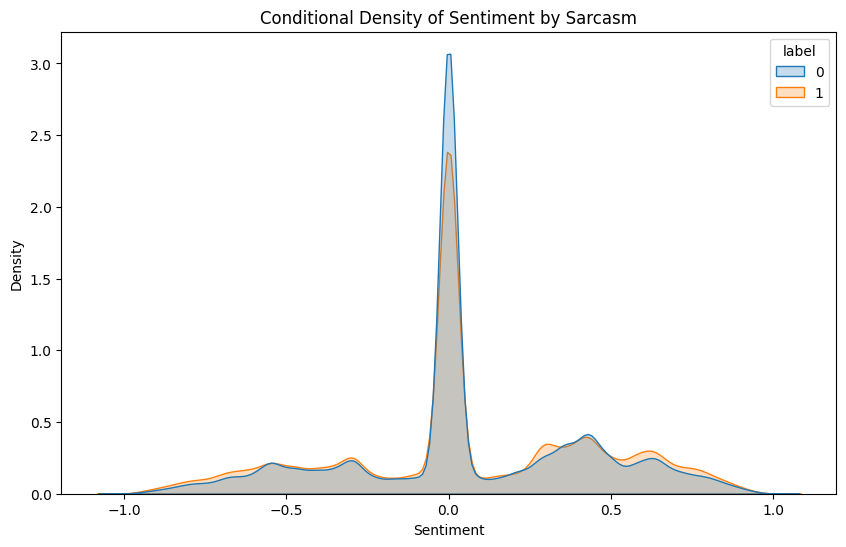

In [81]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=raw_df, x='sentiment', hue='label', fill=True)
plt.title('Conditional Density of Sentiment by Sarcasm')
plt.xlabel('Sentiment')
plt.ylabel('Density')
plt.show()

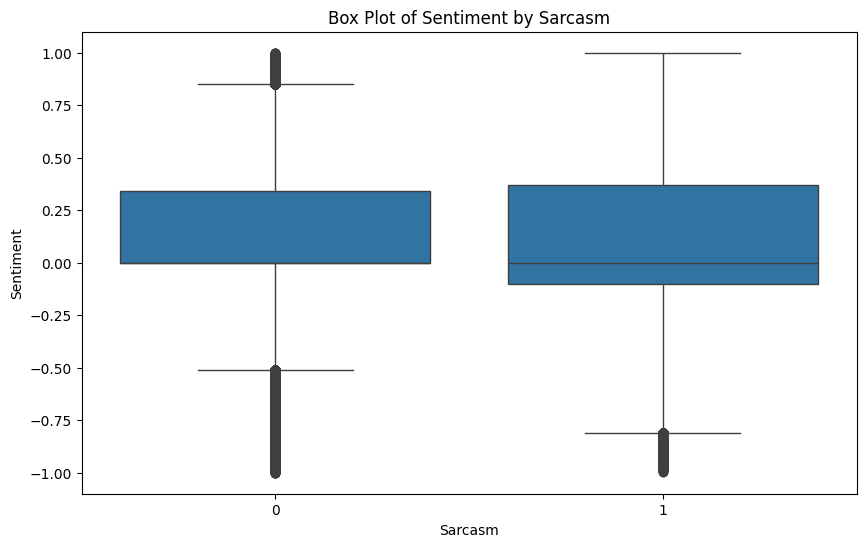

In [80]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='label', y='sentiment', data=raw_df)
plt.title('Box Plot of Sentiment by Sarcasm')
plt.xlabel('Sarcasm')
plt.ylabel('Sentiment')
plt.show()

In [23]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(raw_df['label'], raw_df['sentiment'])
print(contingency_table)

sentiment       0       1
label                    
0          292932  212471
1          263181  242187


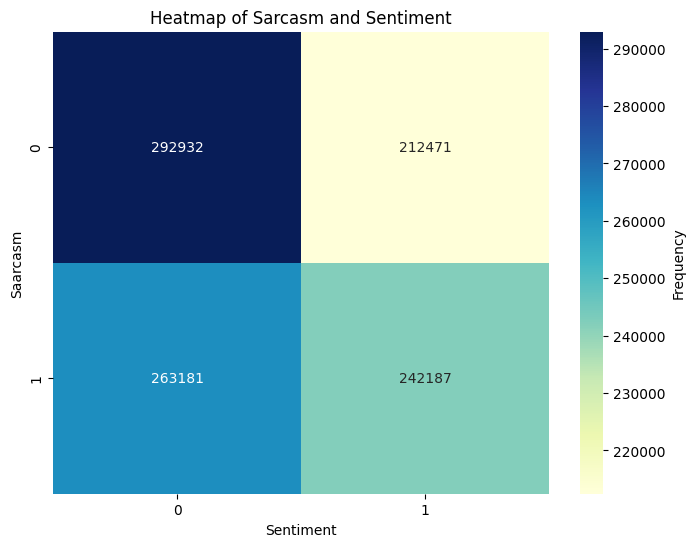

In [79]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='g', cmap="YlGnBu", cbar_kws={'label': 'Frequency'})

plt.title('Heatmap of Sarcasm and Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Saarcasm')
plt.show()
